In [1]:
#! pip install botocore==1.12.201

In [2]:
#! jupyter nbextension enable jupyter-black-master/jupyter-black

In [3]:
#! pip install shap

In [4]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.image_uris import retrieve

import deep_id_pytorch

from lstm_models import *
from lstm_utils import *
from xgboost_utils import *

In [5]:
%load_ext autoreload

%autoreload 2

## OPTIONS

In [6]:
nrows = 1000
min_freq = 1

seq_len = 30

train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)

model_save_path = './output/{}/lstm/model'.format(seq_len)
results_save_path = "./output/{}/lstm/results".format(seq_len)
batch_size = 64

n_epochs = 10
stop_num = 6

embedding_dim = 8
hidden_dim = 16
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

rev = False

In [7]:
for fp in [model_save_path, results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available: True


## Create Vocab and Build Dataset

In [8]:
train_dataset, vocab = build_lstm_dataset(
                                train_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=None,
                                nrows=nrows,
                                rev=rev
                            )
valid_dataset, _ = build_lstm_dataset(
                                valid_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

test_dataset, _ = build_lstm_dataset(
                                test_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

## Model Training

In [10]:
model = SimpleLSTM(embedding_dim, hidden_dim, vocab, model_device)
model = model.cuda()

In [11]:
model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [12]:
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.9)

In [106]:
best_valid_loss = float("inf")
valid_worse_loss = 0  # enable early stopping


for epoch in range(n_epochs):

    start_time = time.time()

    train_loss, train_auc = epoch_train_lstm(
        model, train_dataloader, optimizer, loss_function
    )

    valid_loss, valid_auc = epoch_val_lstm(
       model, valid_dataloader, loss_function)#, return_preds=False
    #)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print("Saved Model, epoch {}".format(epoch))
        valid_worse_loss = 0

    else:
        valid_worse_loss += 1
        if valid_worse_loss == stop_num:
            print("EARLY STOP ------")
            break

    scheduler.step()
    print(
        f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f}"
    )

model.load_state_dict(torch.load(model_save_path))
test_loss, test_auc = epoch_val_lstm(
   model, test_dataloader, loss_function)#, return_preds=False

print(f"Test Loss: {test_loss:.3f} | Test AUC: {test_auc:.2f}")

Epoch: 01 | Epoch Time: 0m 0s
Saved Model, epoch 0
Train Loss: 0.320 | Train AUC: 0.93 	 Val. Loss: 0.290 |  Val. AUC: 0.9316
Epoch: 02 | Epoch Time: 0m 0s
Saved Model, epoch 1
Train Loss: 0.314 | Train AUC: 0.93 	 Val. Loss: 0.283 |  Val. AUC: 0.9318
Epoch: 03 | Epoch Time: 0m 0s
Train Loss: 0.305 | Train AUC: 0.94 	 Val. Loss: 0.312 |  Val. AUC: 0.9283
Epoch: 04 | Epoch Time: 0m 0s
Saved Model, epoch 3
Train Loss: 0.291 | Train AUC: 0.94 	 Val. Loss: 0.279 |  Val. AUC: 0.9339
Epoch: 05 | Epoch Time: 0m 0s
Train Loss: 0.289 | Train AUC: 0.95 	 Val. Loss: 0.290 |  Val. AUC: 0.9303
Epoch: 06 | Epoch Time: 0m 0s
Train Loss: 0.276 | Train AUC: 0.95 	 Val. Loss: 0.329 |  Val. AUC: 0.9257
Epoch: 07 | Epoch Time: 0m 0s
Train Loss: 0.295 | Train AUC: 0.95 	 Val. Loss: 0.376 |  Val. AUC: 0.9011
Epoch: 08 | Epoch Time: 0m 0s
Train Loss: 0.353 | Train AUC: 0.92 	 Val. Loss: 0.365 |  Val. AUC: 0.9047
Epoch: 09 | Epoch Time: 0m 0s
Train Loss: 0.307 | Train AUC: 0.93 	 Val. Loss: 0.304 |  Val. AUC:

## Get SHAP values

In [82]:
#index of the patient where you get compute shap
idx = 1

In [15]:
background = next(iter(train_dataloader))
background_ids, background_labels, background_idxes = background

In [16]:
background_idxes.shape

torch.Size([64, 30])

In [17]:
bg_data, bg_masks = model.get_all_ids_masks(background_idxes, seq_len)

In [18]:
bg_data.shape

torch.Size([64, 30, 32])

In [19]:
explainer = deep_id_pytorch.CustomPyTorchDeepIDExplainer(model, bg_data, bg_masks,
                                                         gpu_memory_efficient=True)

64it [00:00, 741.02it/s]


In [20]:
model.train() # in case that shap complains that autograd cannot be called
lstm_values = []
features = []
start = 0

In [21]:
#test = list(test_dataloader)[3]
test = next(iter(test_dataloader))
test_ids, test_labels, test_idxes = test

In [83]:
#test_labels

In [22]:
test_idxes.shape

torch.Size([64, 30])

In [23]:
test_data, test_masks = model.get_all_ids_masks(test_idxes, seq_len)

In [24]:
test_data.shape

torch.Size([64, 30, 32])

In [25]:
np.array(test_masks[0])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0])

In [26]:
len(test_masks[0])

30

In [27]:
lstm_shap_values = explainer.shap_values(test_data, test_masks)

128it [00:00, 293.74it/s]
128it [00:00, 294.98it/s]
128it [00:00, 296.95it/s]
128it [00:00, 289.33it/s]
128it [00:00, 290.70it/s]
128it [00:00, 295.49it/s]
128it [00:00, 297.68it/s]
128it [00:00, 299.35it/s]
128it [00:00, 300.40it/s]
128it [00:00, 300.00it/s]
128it [00:00, 299.13it/s]
128it [00:00, 292.21it/s]
128it [00:00, 296.53it/s]
128it [00:00, 299.71it/s]
128it [00:00, 299.97it/s]
128it [00:00, 297.11it/s]
128it [00:00, 297.28it/s]
128it [00:00, 298.08it/s]
128it [00:00, 294.08it/s]
128it [00:00, 289.71it/s]
128it [00:00, 295.71it/s]
128it [00:00, 296.36it/s]
128it [00:00, 289.15it/s]
128it [00:00, 289.45it/s]
128it [00:00, 290.44it/s]
128it [00:00, 291.33it/s]
128it [00:00, 287.33it/s]
128it [00:00, 284.67it/s]
128it [00:00, 286.59it/s]
128it [00:00, 292.50it/s]
128it [00:00, 299.70it/s]
128it [00:00, 299.99it/s]
128it [00:00, 299.01it/s]
128it [00:00, 299.01it/s]
128it [00:00, 290.61it/s]
128it [00:00, 297.73it/s]
128it [00:00, 286.29it/s]
128it [00:00, 288.93it/s]
128it [00:00

In [28]:
lstm_shap_values.shape

(64, 30, 32)

In [84]:
df_lstm_shap, patient_id = get_per_patient_shap(lstm_shap_values, test, model.vocab, idx)

In [85]:
patient_id

'6RIF373HSI'

In [86]:
df_lstm_shap

,events,shap_vals
0,headache,-0.096163
1,ankle_sprain,-0.031419
2,cold_sore,0.044668
3,high_creatinine,-0.017616
4,apnea,0.001697
5,pneumonia,-0.028342
6,<pad>,0.000000
7,<pad>,0.000000
8,<pad>,0.000000
9,<pad>,0.000000


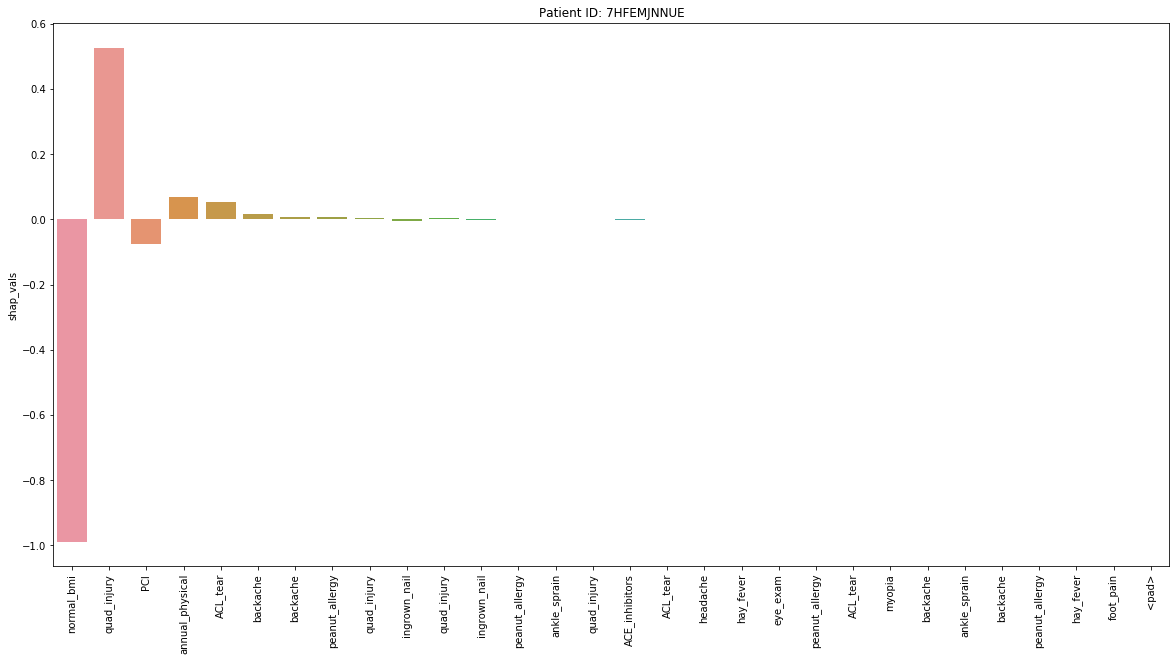

In [33]:
plot_shap_values(df_lstm_shap, patient_id, sort=True)

## XGBoost

### Data Preprocessing

In [34]:
x_train_one_hot_path = 'output/{}/xgboost/data/train_one_hot.csv'.format(seq_len)
x_valid_one_hot_path = 'output/{}/xgboost/data/val_one_hot.csv'.format(seq_len)
x_test_one_hot_path = 'output/{}/xgboost/data/test_one_hot.csv'.format(seq_len)

x_train_data_path = 'output/{}/xgboost/data/train.csv'.format(seq_len)
x_valid_data_path = 'output/{}/xgboost/data/val.csv'.format(seq_len)
x_test_data_path = 'output/{}/xgboost/data/test.csv'.format(seq_len)

s3_output_data_dir = 's3://merck-paper-bucket/{}/data'.format(seq_len)

In [35]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,1279,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,cold_sore,cut_finger,hay_fever,PH,apnea,1,T8MY5WMELF
1,2634,<pad>,<pad>,hay_fever,ingrown_nail,cut_finger,low_salt_diet,ingrown_nail,cold_sore,headache,...,quad_injury,backache,backache,cold_sore,cut_finger,myopia,myopia,eye_exam,0,NTE5E431A7
2,1653,<pad>,<pad>,headache,cut_finger,peanut_allergy,ingrown_nail,myopia,pneumonia,quad_injury,...,foot_pain,eye_exam,ankle_sprain,dental_exam,apnea,foot_pain,cold_sore,ACL_tear,1,VWT8TZSHU8
3,1135,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore,dental_exam,eye_exam,myopia,peanut_allergy,backache,cold_sore,dental_exam,1,FUWNH10AHI
4,2886,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain,eye_exam,ankle_sprain,eye_exam,annual_physical,foot_pain,cold_sore,backache,1,YRWCVEYKWW


In [36]:
def get_valid_tokens(tokens):
    """Get all tokens except <pad> and <unk>"""
    my_tokens = []
    for key, val in tokens.items():
        if val>=2:
            my_tokens.append(key)
    my_tokens
    return my_tokens

In [37]:
tokens = model.vocab._vocab
my_tokens = get_valid_tokens(tokens)

In [38]:
df.head()

,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,1279,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,cold_sore,cut_finger,hay_fever,PH,apnea,1,T8MY5WMELF
1,2634,<pad>,<pad>,hay_fever,ingrown_nail,cut_finger,low_salt_diet,ingrown_nail,cold_sore,headache,...,quad_injury,backache,backache,cold_sore,cut_finger,myopia,myopia,eye_exam,0,NTE5E431A7
2,1653,<pad>,<pad>,headache,cut_finger,peanut_allergy,ingrown_nail,myopia,pneumonia,quad_injury,...,foot_pain,eye_exam,ankle_sprain,dental_exam,apnea,foot_pain,cold_sore,ACL_tear,1,VWT8TZSHU8
3,1135,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore,dental_exam,eye_exam,myopia,peanut_allergy,backache,cold_sore,dental_exam,1,FUWNH10AHI
4,2886,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain,eye_exam,ankle_sprain,eye_exam,annual_physical,foot_pain,cold_sore,backache,1,YRWCVEYKWW


In [40]:
prepare_data(train_data_path, x_train_one_hot_path, x_train_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)
prepare_data(valid_data_path, x_valid_one_hot_path, x_valid_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)
prepare_data(test_data_path, x_test_one_hot_path, x_test_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)

Sucess!
Sucess!
Sucess!


### XGBoost Model Training

In [ ]:
BUCKET = 'merck-paper-bucket'
DATA_PREFIX = '{}/data'.format(seq_len)
MODEL_PREFIX = '{}/xgboost/model'.format(seq_len)
label = 'label'

output_results_path = 'output/{}/xgboost/models/train_results.csv'.format(seq_len)
local_model_dir = 'output/{}/xgboost/models/'
s3_output_path = 's3://{}/{}/output'.format(BUCKET, MODEL_PREFIX)

###Algorithm config
ALGORITHM = 'xgboost'
REPO_VERSION = '1.2-1'

###Hyperparameter tuning config
TRAIN_INSTANCE_TYPE = 'ml.m5.4xlarge'#'ml.m4.16xlarge'
TRAIN_INSTANCE_COUNT = 1
MAX_PARALLEL_JOBS = 1#4 #TODO: Remove
MAX_TRAIN_JOBS = 1#20

EVALUATION_METRIC = 'auc'
OBJECTIVE = 'binary:logistic'
OBJECTIVE_METRIC_NAME = 'validation:auc'

#Update hyperparameter ranges
# HYPERPARAMETER_RANGES = {'eta': ContinuousParameter(0, 1),
#                         'alpha': ContinuousParameter(0, 2),
#                         'max_depth': IntegerParameter(1, 10)}

HYPERPARAMETER_RANGES = {'eta': ContinuousParameter(0.1, 0.5),
                       'alpha': ContinuousParameter(0, 2),
                       'max_depth': IntegerParameter(1, 10),
                       'gamma': ContinuousParameter(0, 5),
                       'num_round': IntegerParameter(200, 500),
                       'colsample_bylevel': ContinuousParameter(0.1, 1.0),
                       'colsample_bynode': ContinuousParameter(0.1, 1.0),
                       'colsample_bytree': ContinuousParameter(0.5, 1.0),
                       'lambda': ContinuousParameter(0, 1000),
                       'max_delta_step': IntegerParameter(0, 10),
                       'min_child_weight': ContinuousParameter(0, 120),
                       'subsample': ContinuousParameter(0.5, 1.0),
                       }


### SageMaker Initialization
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client('sagemaker')

sess = sagemaker.Session()

container = retrieve(ALGORITHM, region, version=REPO_VERSION)

start = time.time()
print('Training for seq_len={}, label={}...'.format(seq_len, label))
#Prepare the input train & validation data path
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(BUCKET, DATA_PREFIX), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/val'.format(BUCKET, DATA_PREFIX), content_type='csv')

#Class Imbalance
scale_pos_weight = 1.0 # negative/positive

data_channels = {'train': s3_input_train, 'validation': s3_input_validation}

tuner = train_hpo(hyperparameter_ranges=HYPERPARAMETER_RANGES, 
                  container=container, 
                  execution_role=role, 
                  instance_count=TRAIN_INSTANCE_COUNT, 
                  instance_type=TRAIN_INSTANCE_TYPE, 
                  output_path=s3_output_path, 
                  sagemaker_session=sess, 
                  eval_metric=EVALUATION_METRIC, 
                  objective=OBJECTIVE, 
                  objective_metric_name=OBJECTIVE_METRIC_NAME, 
                  max_train_jobs=MAX_TRAIN_JOBS, 
                  max_parallel_jobs=MAX_PARALLEL_JOBS, 
                  scale_pos_weight=scale_pos_weight, 
                  data_channels=data_channels)

#Get the hyperparameter tuner status at regular interval
val_auc, best_model_path = get_tuner_status_and_result_until_completion(tuner, seq_len, label)

result = [label, seq_len, val_auc, best_model_path]
training_results = [result]

print('Success! Total training time={} mins.'.format((time.time()-start)/60.0))
#Save the results to file
df_results = pd.DataFrame(training_results, columns=['class', 'seq_len', 'val_auc', 'best_model_path'])

if not os.path.isdir(os.path.split(output_results_path)[0]):
    os.makedirs(os.path.split(output_results_path)[0])

df_results.to_csv(output_results_path, index=False)
print('ALL SUCCESS!')

### XGBoost SHAP

In [52]:
output_results_path = 'output/{}/xgboost/models/train_results.csv'.format(seq_len)
local_model_dir = 'output/{}/xgboost/models/'.format(seq_len)

In [53]:
df_train = pd.read_csv(x_train_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [54]:
df_train.head()

,patient_id,cold_sore,cut_finger,hay_fever,PH,apnea,ingrown_nail,low_salt_diet,headache,dental_exam,...,tachycardia,ARR,high_creatinine,resistent_hyp,PCI,normal_bmi,cardiac_rehab,ACE_inhibitors,AMI,label
0,T8MY5WMELF,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,NTE5E431A7,1,1,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,VWT8TZSHU8,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,FUWNH10AHI,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,YRWCVEYKWW,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [55]:
X_train = df_train.iloc[:, 1:-1]
X_test = df_test.iloc[:, 1:-1]
print(X_train.shape)
print(X_test.shape)

(18000, 30)
(6000, 30)


In [56]:
X_train.head()

,cold_sore,cut_finger,hay_fever,PH,apnea,ingrown_nail,low_salt_diet,headache,dental_exam,peanut_allergy,...,CHF,tachycardia,ARR,high_creatinine,resistent_hyp,PCI,normal_bmi,cardiac_rehab,ACE_inhibitors,AMI
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,0


In [57]:
df_best = pd.read_csv(output_results_path)
df_best

,class,seq_len,val_auc,best_model_path
0,label,30,0.9116,s3://merck-paper-bucket/30/xgboost/model/outpu...


In [58]:
s3_best_model_path = df_best.iloc[0]['best_model_path']
s3_best_model_path

's3://merck-paper-bucket/30/xgboost/model/output/sagemaker-xgboost-201217-2313-001-4901d7a1/output/model.tar.gz'

In [59]:
#Copy the best model from s3 to local
output_path = copy_model_from_s3(s3_best_model_path, local_model_dir)
#Load the copied model
xgb_model = load_model(output_path)

In [60]:
explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = explainer.shap_values(X_test)

In [61]:
xgb_shap_values.shape

(6000, 30)

In [62]:
events = X_test.columns.tolist()
events

['cold_sore',
 'cut_finger',
 'hay_fever',
 'PH',
 'apnea',
 'ingrown_nail',
 'low_salt_diet',
 'headache',
 'dental_exam',
 'peanut_allergy',
 'ankle_sprain',
 'backache',
 'annual_physical',
 'quad_injury',
 'myopia',
 'eye_exam',
 'pneumonia',
 'ACL_tear',
 'foot_pain',
 'furosemide',
 'CHF',
 'tachycardia',
 'ARR',
 'high_creatinine',
 'resistent_hyp',
 'PCI',
 'normal_bmi',
 'cardiac_rehab',
 'ACE_inhibitors',
 'AMI']

In [93]:
idx

1

In [98]:
xgb_shap_values[0]

array([ 0.02348849,  0.05649492,  0.02611071, -0.02545551,  0.02368209,
        0.01285421,  0.08639617, -0.01757945, -0.0791913 ,  0.06433883,
       -0.00501801,  0.01213028,  0.01325664,  0.04899673, -0.03393947,
       -0.02133737,  0.01056913,  0.01452525, -0.02126582,  0.0274704 ,
       -0.0239562 ,  0.08684025, -0.02673383,  0.01335636,  0.07629805,
       -0.897315  , -0.67063266,  0.07063062, -0.7660624 , -0.02418714],
      dtype=float32)

In [99]:
xgb_shap_values[1]

array([ 0.03070479, -0.00244325,  0.04259351, -0.02525498,  0.00764192,
        0.02194856,  0.4212526 ,  0.08939369,  0.00972095,  0.05641354,
        0.0005042 , -0.06357393,  0.00540417, -0.03605811,  0.02365076,
       -0.01284034,  0.05127279,  0.08336215, -0.14695501,  0.01082196,
       -0.01666935,  0.00662311, -0.02496707,  0.03906865, -0.00774697,
        0.49460393,  0.49806052,  0.36014262,  0.3813592 , -0.02271443],
      dtype=float32)

In [100]:
patient_id = df_test.patient_id[idx]
pat_shap_values = xgb_shap_values[idx]

In [95]:
patient_id

'6RIF373HSI'

In [89]:
pat_shap_values.shape

(30,)

In [90]:
df_lstm_shap

,events,shap_vals
0,headache,-0.096163
1,ankle_sprain,-0.031419
2,cold_sore,0.044668
3,high_creatinine,-0.017616
4,apnea,0.001697
5,pneumonia,-0.028342
6,<pad>,0.000000
7,<pad>,0.000000
8,<pad>,0.000000
9,<pad>,0.000000


In [ ]:
xgboost

In [91]:
df_lstm_shap.reindex(df_lstm_shap.shap_vals.abs().sort_values(ascending=False).index).reset_index()

,index,events,shap_vals
0,0,headache,-0.096163
1,2,cold_sore,0.044668
2,1,ankle_sprain,-0.031419
3,5,pneumonia,-0.028342
4,3,high_creatinine,-0.017616
5,4,apnea,0.001697
6,28,<pad>,0.000000
7,6,<pad>,0.000000
8,7,<pad>,0.000000
9,8,<pad>,0.000000


In [102]:
df.reindex(df.shap_vals.abs().sort_values(ascending=False).index).reset_index()

,index,events,shap_vals
0,26,normal_bmi,0.498061
1,25,PCI,0.494604
2,6,low_salt_diet,0.421253
3,28,ACE_inhibitors,0.381359
4,27,cardiac_rehab,0.360143
5,18,foot_pain,-0.146955
6,7,headache,0.089394
7,17,ACL_tear,0.083362
8,11,backache,-0.063574
9,9,peanut_allergy,0.056414


In [101]:
df = pd.DataFrame(np.array([events, pat_shap_values]).T, columns=['events', 'shap_vals'])
df["shap_vals"] = pd.to_numeric(df["shap_vals"])
df

,events,shap_vals
0,cold_sore,0.030705
1,cut_finger,-0.002443
2,hay_fever,0.042594
3,PH,-0.025255
4,apnea,0.007642
5,ingrown_nail,0.021949
6,low_salt_diet,0.421253
7,headache,0.089394
8,dental_exam,0.009721
9,peanut_allergy,0.056414


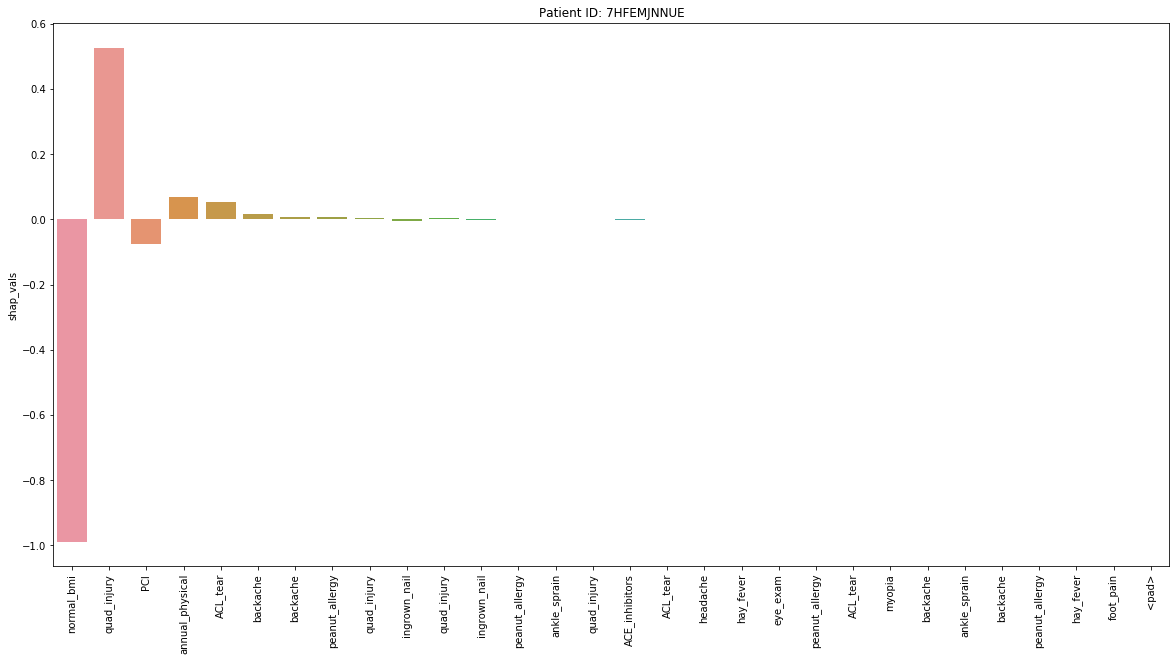

In [71]:
plot_shap_values(df_lstm_shap, patient_id, sort=True)

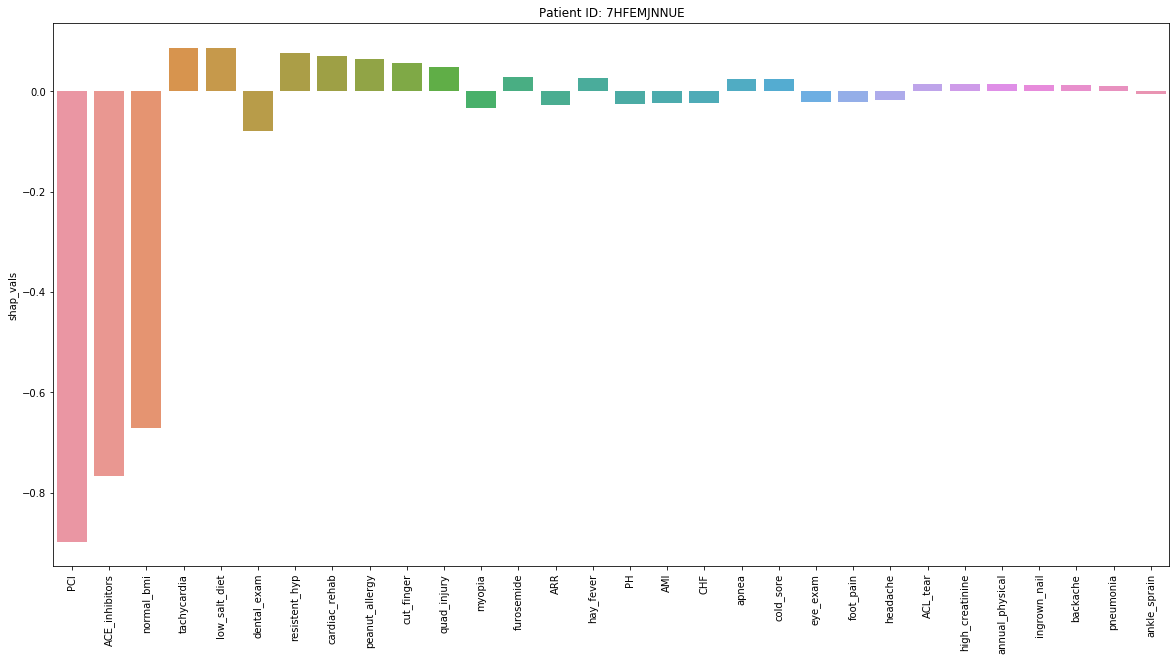

In [67]:
plot_shap_values(df, patient_id, sort=True)

In [69]:
test_auc = xgb_model.eval(xgb.DMatrix(X_test.values, df_test[target_colname].values))
test_auc

'[0]\teval-auc:0.905075'

In [ ]:
auc

In [72]:
lstm_shap_values.shape

(64, 30, 32)

In [103]:
xgb_shap_values.shape

(6000, 30)

In [105]:
lstm_shap_values[0].shape

(30, 32)